In [1]:
import keras

from keras import layers
# from keras import ops
# from tensorflow_docs.vis import embed
import tensorflow as tf
import numpy as np
import imageio
import tensorflow as tf
print(tf.__version__)

import numpy as np
import imageio, os
from gan_model import CGAN
from utils import generate_and_save_images
from sklearn.model_selection import train_test_split


import imgaug.augmenters as iaa

2.10.1


In [2]:

def make_discriminator_model(discriminator_in_channels):
    # Create the discriminator.
    discriminator = tf.keras.Sequential(
        [
            tf.keras.layers.InputLayer((28, 28, discriminator_in_channels)),
            layers.Conv2D(64, (3, 3), strides=(2, 2), padding="same"),
            layers.LeakyReLU(0.2),
            layers.Conv2D(128, (3, 3), strides=(2, 2), padding="same"),
            layers.LeakyReLU(0.2),
            layers.GlobalMaxPooling2D(),
            layers.Dense(1),
        ],
        name="discriminator",
    )
    return discriminator

def make_generator_model(generator_in_channels):
# Create the generator.
    generator = tf.keras.Sequential(
        [
            tf.keras.layers.InputLayer((generator_in_channels,)),
            # We want to generate 128 + num_classes coefficients to reshape into a
            # 7x7x(128 + num_classes) map.
            layers.Dense(7 * 7 * generator_in_channels),
            layers.LeakyReLU(0.2),
            layers.Reshape((7, 7, generator_in_channels)),
            layers.Conv2DTranspose(128, (4, 4), strides=(2, 2), padding="same"),
            layers.LeakyReLU(0.2),
            layers.Conv2DTranspose(128, (4, 4), strides=(2, 2), padding="same"),
            layers.LeakyReLU(0.2),
            layers.Conv2D(1, (7, 7), padding="same", activation="sigmoid"),
        ],
        name="generator",
    )
    return generator

In [3]:
batch_size = 64
num_channels = 1
num_classes = 10
image_size = 28
latent_dim = 128

generator_in_channels = latent_dim + num_classes
discriminator_in_channels = num_channels + num_classes
RANDOM_STATE=42

In [4]:
model_path = "./gan_model/gan_model.keras"
os.makedirs(model_path, exist_ok=True)
model_dir = os.path.dirname(model_path)

In [5]:
checkpoint_path = "training/gan.ckpt"
os.makedirs(checkpoint_path, exist_ok=True)
checkpoint_dir = os.path.dirname(checkpoint_path)

# Create a callback that saves the model's weights
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_weights_only=True,
                                                 verbose=0)

In [6]:
cgan = CGAN(
    discriminator=make_discriminator_model(discriminator_in_channels), 
    generator=make_generator_model(generator_in_channels), latent_dim=latent_dim, 
    image_size=image_size, num_classes=num_classes
)

cgan.compile(
    d_optimizer=tf.keras.optimizers.Adam(learning_rate=0.0003),
    g_optimizer=tf.keras.optimizers.Adam(learning_rate=0.0003),
    loss_fn=tf.keras.losses.BinaryCrossentropy(from_logits=True)
)

In [7]:
aug_seq = iaa.Sequential([
            iaa.Rotate((-10, 10), random_state=RANDOM_STATE),                 
            iaa.ShearX((-10, 10), random_state=RANDOM_STATE),                  
            iaa.ShearY((-10, 10), random_state=RANDOM_STATE),
        ])

def augment(image):
    image = aug_seq.augment_image(image)
    return image

In [8]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()
_, x_train, _, y_train = train_test_split(x_train, y_train, test_size=0.5, random_state=42)
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.1, random_state=42) 
all_digits = np.concatenate([x_train, x_test])
all_labels = np.concatenate([y_train, y_test])

In [9]:
unique, counts = np.unique(y_train, return_counts=True)
dict(zip(unique, counts))


{0: 2687,
 1: 3010,
 2: 2624,
 3: 2771,
 4: 2644,
 5: 2484,
 6: 2704,
 7: 2840,
 8: 2575,
 9: 2661}

In [10]:

# Scale the pixel values to [0, 1] range, add a channel dimension to
# the images, and one-hot encode the labels.
x_train_aug = np.asarray([augment(x) for x in x_train.astype("float32")])
x_train = x_train.astype("float32") / 255.0
x_train_aug = x_train_aug.astype("float32") / 255.0


In [11]:
print(np.max(x_train_aug))

1.0


In [12]:
x_train = np.concatenate([x_train, np.array(x_train_aug)])
y_train = np.concatenate([y_train, y_train])

In [13]:
x_train = np.reshape(x_train, (-1, 28, 28, 1))
y_train = tf.keras.utils.to_categorical(y_train, 10)

x_val = x_val.astype("float32") / 255.0
x_val = np.reshape(x_val, (-1, 28, 28, 1))
y_val = tf.keras.utils.to_categorical(y_val, 10)

train_dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train))

train_dataset = train_dataset.shuffle(buffer_size=1024).batch(batch_size)

val_dataset = tf.data.Dataset.from_tensor_slices((x_val, y_val))
val_dataset = val_dataset.shuffle(buffer_size=1024).batch(batch_size)

print(f"Shape of training images: {x_train.shape}")
print(f"Shape of training labels: {y_train.shape}")

Shape of training images: (54000, 28, 28, 1)
Shape of training labels: (54000, 10)


In [14]:
epochs = 30
cgan.compiled_metrics == None

cgan.fit(train_dataset, epochs=epochs, validation_data=val_dataset)

cgan.generator.save("mnist_gan.keras")

Epoch 1/30
844/844 [==============================] - 37s 39ms/step - g_loss: 1.5686 - d_loss: 0.3974 - val_g_loss: 0.9614 - val_d_loss: 0.7078
Epoch 2/30
844/844 [==============================] - 32s 38ms/step - g_loss: 1.3387 - d_loss: 0.4999 - val_g_loss: 1.3155 - val_d_loss: 0.4179
Epoch 3/30
844/844 [==============================] - 32s 38ms/step - g_loss: 1.8844 - d_loss: 0.3250 - val_g_loss: 4.8167 - val_d_loss: 0.0257
Epoch 4/30
844/844 [==============================] - 32s 38ms/step - g_loss: 3.4486 - d_loss: 0.1529 - val_g_loss: 3.5486 - val_d_loss: 0.1826
Epoch 5/30
844/844 [==============================] - 32s 38ms/step - g_loss: 2.8520 - d_loss: 0.1424 - val_g_loss: 4.7502 - val_d_loss: 0.2127
Epoch 6/30
844/844 [==============================] - 33s 39ms/step - g_loss: 3.2967 - d_loss: 0.0984 - val_g_loss: 3.0165 - val_d_loss: 1.1366
Epoch 7/30
844/844 [==============================] - 33s 39ms/step - g_loss: 1.4407 - d_loss: 0.5800 - val_g_loss: 0.8839 - val_d_loss:

tf.Tensor([18 10], shape=(2,), dtype=int32)
tf.Tensor([ 18 128], shape=(2,), dtype=int32)
tf.Tensor([ 18 128], shape=(2,), dtype=int32)


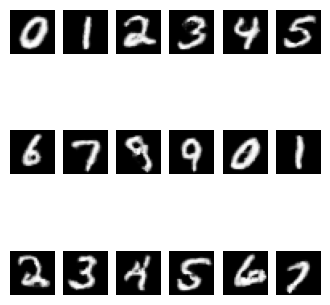

In [15]:
cgan = tf.keras.models.load_model("mnist_gan.keras")

labels = [i%10 for i in range(18)]
one_hot_labels = tf.keras.utils.to_categorical(labels, num_classes)
print(tf.shape(one_hot_labels))

# Sample random points in the latent space.
random_latent_vectors = tf.random.normal(
    shape=(18, latent_dim), seed=1337
)
print(tf.shape(random_latent_vectors))

random_vector_labels = tf.concat(
    [random_latent_vectors, one_hot_labels], axis=1
)

print(tf.shape(random_latent_vectors))

# Generate after the final epoch
generate_and_save_images(cgan,
                        epochs,
                        random_vector_labels)